# Hopping Parameter Extraction

You can download source files to follow this tutorial from this [link](https://vachoppy.readthedocs.io/en/latest/tutorials/api/vacancy_trajectory.html)

---

Calculating effective hopping parameters relies on the `Calculator()` factory function and the `Site` class. For a detailed explanation of these core components, please refer to the previous tutorial.

First, navigate to the `Example3` directory you downloaded. Inside, you will find three items: the `TRAJ_TiO2` directory, a `POSCAR_TiO2` file, and a `neb.csv` file.

The `TRAJ_TiO2` directory contains a thermal ensemble of HDF5 trajectory files from MD simulations performed at various temperatures. This example includes simulations from 1700 K to 2100 K, with 20 independent runs at each temperature.

The file structure is as follows:

```bash
TRAJ_TiO2/
├── TRAJ_1700K/
│   ├── TRAJ_O_01.h5
│   ├──    ...
│   └── TRAJ_O_20.h5
├── TRAJ_1800K/
│   ├── TRAJ_O_01.h5
│   ├──    ...
│   └── TRAJ_O_20.h5
├── TRAJ_1900K/
│   ├── TRAJ_O_01.h5
│   ├──    ...
│   └── TRAJ_O_20.h5
├── TRAJ_2000K/
│   ├── TRAJ_O_01.h5
│   ├──    ...
│   └── TRAJ_O_20.h5
└── TRAJ_2100K/
    ├── TRAJ_O_01.h5
    ├──    ...
    └── TRAJ_O_20.h5
 ```

A key advantage of `VacHopPy` is its ability to process a large number of trajectories from multiple NVT ensembles simultaneously and in a memory-efficient way.

In [23]:
import os
import numpy as np
import pandas as pd
from vachoppy.core import Site, Calculator

path_traj = 'TRAJ_TiO2'
path_structure = 'POSCAR_TiO2'
if not os.path.exists(path_traj): print(f"{path_traj} not found.")
if not os.path.exists(path_structure): print(f"{path_structure} not found.")

---
## 1. Usage Example

### - Creating the `Site` and `CalculatorEnsemble` Instances

The first step in our analysis is to define the crystal's structural framework by creating a `Site` instance. This object analyzes a **perfect, vacancy-free supercell** to identify all **lattice sites** and **hopping paths**.

Next, we pass this `Site` object to the `Calculator()` factory function. This function automatically processes all trajectories found in `path_traj`. A key feature is its ability to automatically determine an optimal `t_interval`.

In [12]:
site = Site(path_structure, 'O')
calc_ensemble = Calculator(path_traj, site)

                   Automatic t_interval Estimation
  [1700.0 K] Estimating from TRAJ_1700K/TRAJ_O_01.h5
             -> t_interval : 0.075 ps
  [1800.0 K] Estimating from TRAJ_1800K/TRAJ_O_01.h5
             -> t_interval : 0.075 ps
  [1900.0 K] Estimating from TRAJ_1900K/TRAJ_O_01.h5
             -> t_interval : 0.075 ps
  [2000.0 K] Estimating from TRAJ_2000K/TRAJ_O_01.h5
             -> t_interval : 0.075 ps
  [2100.0 K] Estimating from TRAJ_2100K/TRAJ_O_01.h5
             -> t_interval : 0.075 ps
        Adjusting t_interval to the nearest multiple of dt
    - dt                  : 0.0020 ps
    - Original t_interval : 0.0750 ps
    - Adjusted t_interval : 0.0740 ps (37 frames)


When `path_traj` points to a directory, `Calculator()` automatically discovers HDF5 files within it. By default, this search extends down to two subdirectory levels (a depth of 2). You can control this search depth using the `depth` argument if your file structure is different.

---
### - Calculating Hopping Parameters

Once the `CalculatorEnsemble` is configured, you can initiate the main analysis by calling the `.calculate()` method.

This method is highly optimized for performance and is designed to handle very large datasets.

* **Memory Efficiency**
    
    It processes trajectories in a **streaming** fashion, loading data in small chunks to minimize RAM usage.

* **Speed** 

    It leverages **parallel processing** to perform computations on multiple CPU cores simultaneously, significantly speeding up the analysis. You can control the number of CPU cores used for this parallel computation with the `n_jobs` argument. Setting `n_jobs=-1` will use all available cores.

In [14]:
calc_ensemble.calculate()

Analyze Trajectory:   0%|                              | 0/100 [00:00<?, ?it/s]


Analysis complete: 100 successful, 0 failed.
Execution Time: 21.477 seconds
Peak RAM Usage: 1.153 GB


This method processes all HDF5 files found within the `path_traj` directory, calculating the vacancy hopping properties for each one. The results from each individual file are then stored in the `.calculators` attribute as a list of `CalculatorSingle` objects.

You can inspect the first few results to see which files were processed:

In [18]:
print(f"Number of Data: {len(calc_ensemble.calculators)}\n")

# Display the file paths for the first three results
for i, calc in enumerate(calc_ensemble.calculators[:3]):
    print(f"[Index {i}] : {calc.path_traj}")

Number of Data: 100

[Index 0] : /home/jty/Examples/Example3/TRAJ_TiO2/TRAJ_1700K/TRAJ_O_01.h5
[Index 1] : /home/jty/Examples/Example3/TRAJ_TiO2/TRAJ_1700K/TRAJ_O_02.h5
[Index 2] : /home/jty/Examples/Example3/TRAJ_TiO2/TRAJ_1700K/TRAJ_O_03.h5


You can now view the calculated hopping parameters for each trajectory by calling the `.summary()` method.

In [19]:
calc_ensemble.summary()

Summary for Trajectory dataset
  - Path to TRAJ bundle : TRAJ_TiO2 (depth=2)
  - Lattice structure   : POSCAR_TiO2
  - t_interval          : 0.074 ps (37 frames)
  - Temperatures (K)    : [1700.0, 1800.0, 1900.0, 2000.0, 2100.0]
  - Num. of TRAJ files  : [20, 20, 20, 20, 20]

==================== Temperature-Dependent Data ====================
T (K)    D (m2/s)    D_rand (m2/s)    f       tau (ps)    a (Ang)
-------  ----------  ---------------  ------  ----------  ---------
1700     4.176e-10   6.413e-10        0.6511  19.092      2.7104
1800     6.097e-10   9.179e-10        0.6642  13.3759     2.7142
1900     8.228e-10   1.249e-09        0.6589  9.938       2.7287
2000     1.099e-09   1.663e-09        0.661   7.4301      2.7227
2100     1.48e-09    2.262e-09        0.6543  5.4597      2.7224

===================== Final Fitted Parameters ======================
Diffusivity (D):
  - Ea          : 0.961 eV
  - D0          : 2.944e-07 m^2/s
  - R-squared   : 0.9991
Random Walk Diffusivit

### - Plotting the Hopping Parameters

`VacHopPy` includes a suite of convenient methods to visualize the calculated hopping parameters as a function of temperature. 

The following table summarizes the available plotting functions:

<div align="center">

| Method | Description |
| :---: | :--- |
| **`plot_D()`** | Generates an Arrhenius plot of the calculated **diffusivity (D)**. |
| **`plot_D_rand()`** | Creates an Arrhenius plot for the **random walk diffusivity (D_rand)**. |
| **`plot_f()`** | Plots the **correlation factor (f)** as a function of temperature. |
| **`plot_tau()`** | Visualizes the **vacancy residence time (tau)** across different temperatures. |
| **`plot_a()`** | Shows the average **hopping distance (a)** as a function of temperature. |
| **`plot_counts()`** | Displays the total **count** for each unique type of hopping path. |

</div>

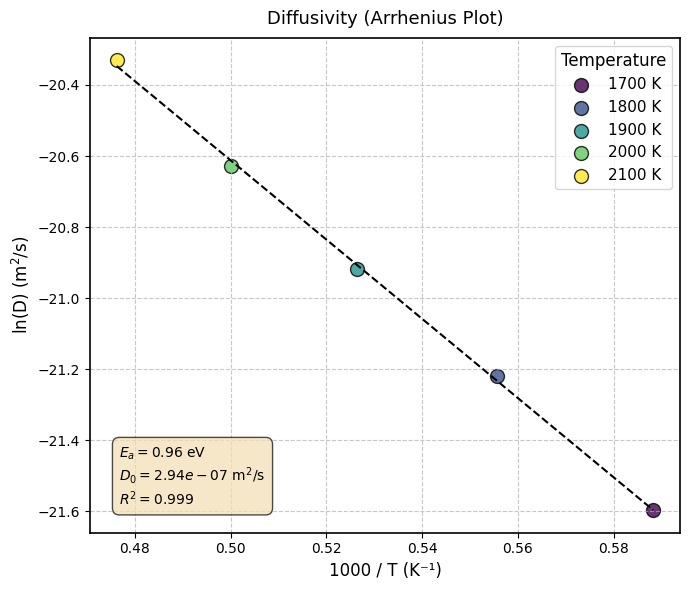

In [8]:
calc_ensemble.plot_D()

#### - Saving the Hopping Parameters

Once your analysis is complete, you can save all the calculated effective hopping parameters to a file using the `.save_parameters()` method. This command exports the results into a `parameters.json` file, making it easy to reload or analyze them later without re-running the entire calculation.

In [33]:
calc_ensemble.save_parameters()

Parameters saved to 'parameters.json'


### - Calculating the Attempt Frequency

To calculate the **effective attempt frequency** ($\nu$) and the **effective coordination number** ($z$), `VacHopPy` requires the pre-calculated energy barriers for each unique type of hopping path.

This information must be provided in a CSV file. Each row in this file should correspond to a specific hopping path and contain its calculated hopping barrier, which is typically obtained from methods like the nudged elastic band (NEB).

Below is an example of the CSV file:

In [29]:
neb_csv = 'neb_TiO2.csv'
if not os.path.exists(neb_csv):
    print(f"'{neb_csv}' not found.")
else:
    data = pd.read_csv(neb_csv)
    print(data)

   A1  0.8698
0  A2   1.058
1  A3   1.766


This calculation is performed by calling the `.calculate_attempt_frequency()` method. Simply provide the path to the CSV file containing the hopping barriers as an argument.

Upon completion, the method will print a summary of the calculation. Additionally, if a `parameters.json` file from a previous run exists, this method will automatically update it by adding the newly calculated attempt frequency and coordination number.


In [31]:
calc_ensemble.calculate_attempt_frequency(neb_csv)

Parameters saved to 'parameters.json'
            Attempt Frequency Analysis Summary

-- Temperature-Dependent Effective Parameters --

Temp (K)    nu (THz)    z
----------  ----------  ------
1700.0      6.1675      5.8920
1800.0      6.0200      5.9904
1900.0      5.7611      6.0862
2000.0      5.6642      6.1788
2100.0      5.8308      6.2682
--------    --------    -
Mean        5.8887      6.0831

-- Path-Wise Parameters (per Temperature) --

Temperature: 1700.0 K
Path Name    Hop Count    nu_path (THz)
-----------  -----------  ---------------
A1           167          7.8923
A2           252          5.3794
A3           1            10.7228
----------------------------------------
Temperature: 1800.0 K
Path Name    Hop Count    nu_path (THz)
-----------  -----------  ---------------
A1           171          7.7409
A2           279          5.3119
A3           0            0
----------------------------------------
Temperature: 1900.0 K
Path Name    Hop Count    nu_path (THz)
--

After running the `.calculate_attempt_frequency()` method, you can visualize its primary results using two newly available plotting functions:

<div align="center">

| Method          | Description                                       |
| :-------------: | :----------------------------------------------------------------- |
| **`plot_nu()`** | Plots the **attempt frequency (nu)** as a function of temperature. |
| **`plot_z()`** | Plots the **coordination number (z)**  as a function of temperature.  |

</div>

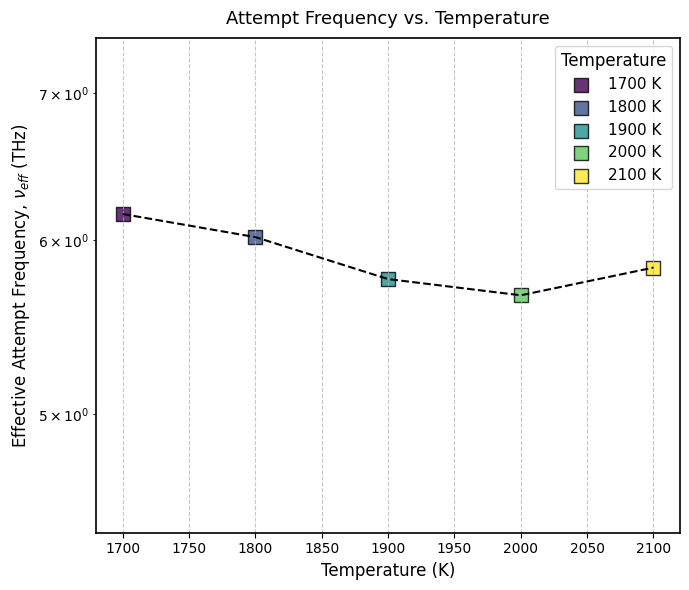

In [32]:
calc_ensemble.plot_nu()